# Load data and packages

In [ ]:
import os
import glob
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# #------------tensoflow libraries-----------------
import tensorflow as tf
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.optimizers import Adam

Downloaded image dataset from kaggle and saved in my google drive

In [ ]:
!gdown --id 1alX-3H9Hs3DU1H6XPug31skAq7sGUuEE -O jellyfish.zip

/usr/local/lib/python3.11/dist-packages/gdown/__main__.py:140: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  warnings.warn(
Downloading...
From (original): https://drive.google.com/uc?id=1alX-3H9Hs3DU1H6XPug31skAq7sGUuEE
From (redirected): https://drive.google.com/uc?id=1alX-3H9Hs3DU1H6XPug31skAq7sGUuEE&confirm=t&uuid=b786a99b-fd6d-4643-b5ff-bda3de285472
To: /content/jellyfish.zip
100% 26.8M/26.8M [00:00<00:00, 35.7MB/s]


In [ ]:
!unzip -q jellyfish.zip

In [ ]:
!ls

barrel_jellyfish  compass_jellyfish  lions_mane_jellyfish     Moon_jellyfish  Train_Test_Valid
blue_jellyfish	  jellyfish.zip      mauve_stinger_jellyfish  sample_data


Checking image directories, images are saved in various folders, I will use the Train_Test_Valid folder

In [ ]:
import os
current_directory = os.getcwd()
print(current_directory)

/content


In [ ]:
# check if the directory exists
import os
jellyfish_dir = "/content/Train_Test_Valid"
if os.path.exists(jellyfish_dir):
  print(f"Jellyfish directory found at: {jellyfish_dir}")
else:
  print("Jellyfish directory not found. Please check the path.")

Jellyfish directory found at: /content/Train_Test_Valid


# Image preprocessing and augmentation

In [ ]:
def DataCreation(train_dir, test_dir, val_dir, batch_size):
    #data transformations on train images for data augmentation
    train_datagen = tf.keras.preprocessing.image.ImageDataGenerator(
                      rescale=1./255,
                      rotation_range=15,
                      width_shift_range=0.2,
                      height_shift_range=0.2,
                      shear_range=0.005,
                      zoom_range=[0.95, 1.2], # try to avoid extreme distortions
                      horizontal_flip=True,
                      vertical_flip=False,
                      brightness_range=(.8,1.2),
                      fill_mode='reflect', # can be a better mode when "nearest" cause distortion
                      )
    test_datagen = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1.0/255.0) # no augmentation to the test or validation datasets
    val_datagen = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1.0/255.0)

    # images are stored in folder subdirectories so we use .flow_from_directory
    train_generator = train_datagen.flow_from_directory(train_dir,
                                                      shuffle=True,
                                                      target_size = (224,224),
                                                      class_mode = 'categorical', # this performs one-hot encoding
                                                      batch_size = batch_size)
    test_generator = test_datagen.flow_from_directory(test_dir,
                                                      target_size = (224,224),
                                                      class_mode = 'categorical',
                                                      batch_size = batch_size)
    val_generator = val_datagen.flow_from_directory(val_dir,
                                                      target_size=(224, 224),
                                                      batch_size=batch_size,
                                                      class_mode='categorical')
    return train_generator, test_generator, val_generator


In [ ]:
train_dir= "/content/Train_Test_Valid/Train"
test_dir= "/content/Train_Test_Valid/test"
val_dir= "/content/Train_Test_Valid/valid"
batch_size= 32

train_generator, test_generator, val_generator = DataCreation(train_dir, test_dir, val_dir, batch_size, )

Found 900 images belonging to 6 classes.
Found 40 images belonging to 6 classes.
Found 39 images belonging to 6 classes.


check that the image augmentations look okay

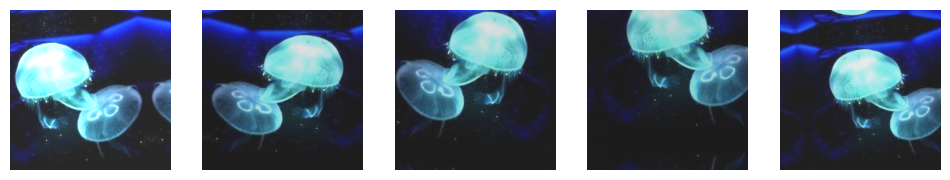

In [ ]:
import matplotlib.pyplot as plt
# Plot 5 augmentations of 1st image in train generator
augmented_images = [train_generator[0][0][0] for i in range(5)]

plt.figure(figsize=(12,12))
for i in range(5):
  plt.subplot(1, 5, i+1) # Arrange plots in a single row
  plt.imshow(augmented_images[i]) # Plot the image directly if RGB
  plt.axis('off')

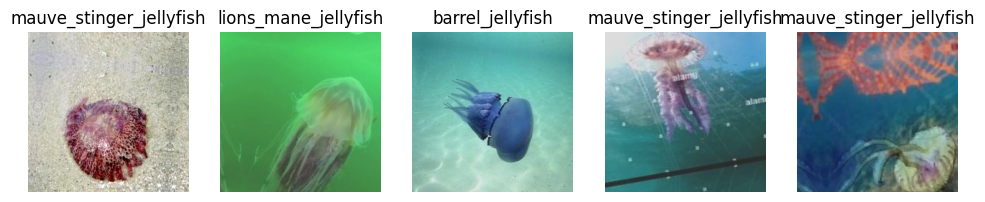

In [ ]:
# Get the first batch of images and labels from the train_generator
images, labels = next(train_generator)

# Get the class indices (mapping from label index to class name)
class_indices = train_generator.class_indices

# Plot 5 images with labels
plt.figure(figsize=(12, 12))
for i in range(5):
    plt.subplot(1, 5, i + 1)
    plt.imshow(images[i])
    # Get the predicted label index
    predicted_label_index = np.argmax(labels[i])
    # Get the class name using class_indices
    predicted_class_name = list(class_indices.keys())[list(class_indices.values()).index(predicted_label_index)]
    plt.title(predicted_class_name)
    plt.axis('off')

# Defining steps size

Because the data-generators will loop for eternity, we need to specify the number of steps to perform during evaluation and prediction.

The model needs a clear definition of steps per epoch, which is calculated below. This tells Keras how many batches make up ONE FULL EPOCH. One epoch will see each image, or an augmenteed version of it, once. This also means, most epochs will see a different augmented version of the respective image - train_generator with datagen_train is called new for each epoch (it could probably happen that the same arguments are chosen and there are repetitons of augmented images)

In [ ]:
steps_train= len(train_generator)
steps_val = len(val_generator)
steps_test = len(test_generator)
num_classes= train_generator.num_classes

steps_train, steps_val, steps_test, num_classes

(29, 2, 2, 6)

# CNN from scratch

In [ ]:
from tensorflow.keras import layers, models
import keras

In [ ]:
# Build a simple CNN from scratch
model = models.Sequential()
model.add(layers.Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same', input_shape=(224,224,3))) # randomly initialize weights based on activation function
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(64, (3, 3), activation='relu', padding='same'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(128, (3, 3), activation='relu', padding='same'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(256, (3, 3), activation='relu', padding='same'))
model.add(layers.Flatten())
model.add(layers.Dense(256, activation='relu'))
model.add(tf.keras.layers.Dropout(0.3))
model.add(layers.Dense(128, activation= "relu"))
#model.add(tf.keras.layers.Dropout(0.3))
#model.add(layers.Dense(256, activation= "relu"))
model.add(tf.keras.layers.Dropout(0.3))
model.add(layers.Dense(num_classes, activation='softmax'))

model.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_8 (Conv2D)                    │ (None, 224, 224, 32)        │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_6 (MaxPooling2D)       │ (None, 112, 112, 32)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_9 (Conv2D)                    │ (None, 112, 112, 64)        │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_7 (MaxPooling2D)       │ (None, 56, 56, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_10 (Conv2D)                   │ (None, 56, 56, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_8 (MaxPooling2D)       │ (None, 28, 28, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_11 (Conv2D)                   │ (None, 28, 28, 256)         │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_2 (Flatten)                  │ (None, 200704)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_7 (Dense)                      │ (None, 256)                 │      51,380,480 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_3 (Dropout)                  │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_8 (Dense)                      │ (None, 128)                 │          32,896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_4 (Dropout)                  │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_9 (Dense)                      │ (None, 6)                   │             774 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 51,802,566 (197.61 MB)

 Trainable params: 51,802,566 (197.61 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
epochs = 30

early_stopping_cb = keras.callbacks.EarlyStopping(patience=10, monitor="val_loss", restore_best_weights=True)
early_stopping_cb

In [ ]:
optimizer=tf.keras.optimizers.Adam(learning_rate=0.001)
model.compile(optimizer=optimizer,
              loss=tf.keras.losses.CategoricalCrossentropy(), # because of one-hot encoding
              # otherwise with multiclass prediction we would use SparseCategoricalCrossentropy()
              metrics=['categorical_accuracy']) # and sparse_categorical_accuracy

history = model.fit(train_generator,
                    epochs=epochs,
                    steps_per_epoch=steps_train,
                    validation_data=val_generator,
                    callbacks=[early_stopping_cb]
                    )

Epoch 1/30
29/29 ━━━━━━━━━━━━━━━━━━━━ 13s 237ms/step - categorical_accuracy: 0.1855 - loss: 2.6898 - val_categorical_accuracy: 0.4103 - val_loss: 1.4891
Epoch 2/30
29/29 ━━━━━━━━━━━━━━━━━━━━ 12s 83ms/step - categorical_accuracy: 0.3612 - loss: 1.6107 - val_categorical_accuracy: 0.4103 - val_loss: 1.3400
Epoch 3/30
29/29 ━━━━━━━━━━━━━━━━━━━━ 2s 78ms/step - categorical_accuracy: 0.4550 - loss: 1.3647 - val_categorical_accuracy: 0.3590 - val_loss: 1.3459
Epoch 4/30
29/29 ━━━━━━━━━━━━━━━━━━━━ 3s 88ms/step - categorical_accuracy: 0.5509 - loss: 1.1704 - val_categorical_accuracy: 0.4359 - val_loss: 1.3192
Epoch 5/30
29/29 ━━━━━━━━━━━━━━━━━━━━ 5s 73ms/step - categorical_accuracy: 0.6260 - loss: 0.9877 - val_categorical_accuracy: 0.5128 - val_loss: 1.3931
Epoch 6/30
29/29 ━━━━━━━━━━━━━━━━━━━━ 2s 71ms/step - categorical_accuracy: 0.7176 - loss: 0.7792 - val_categorical_accuracy: 0.3846 - val_loss: 1.8791
Epoch 7/30
29/29 ━━━━━━━━━━━━━━━━━━━━ 2s 68ms/step - categorical_accuracy: 0.7207 - loss: 0

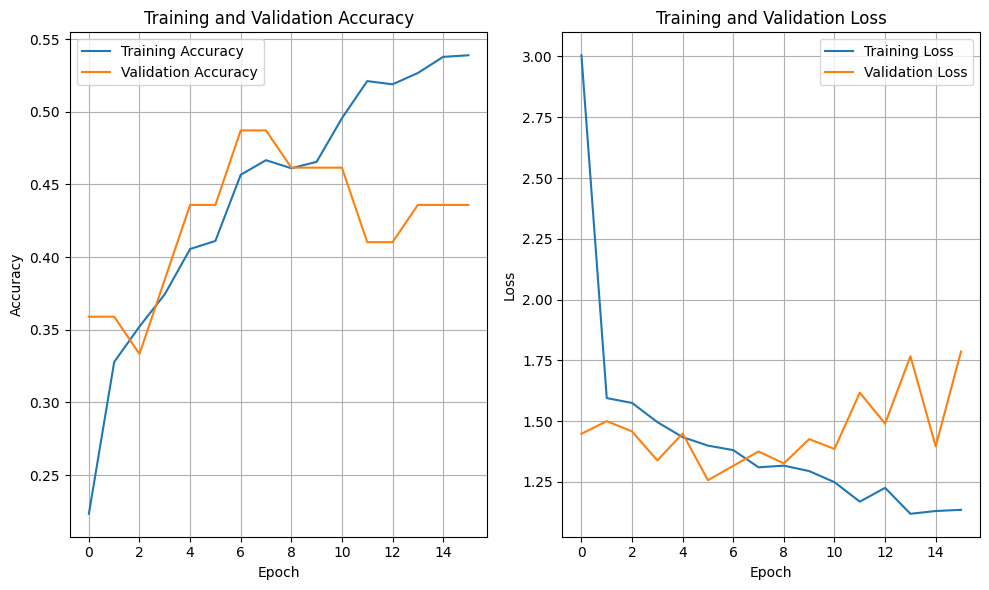

In [ ]:
# Plot the training history.

def plot_history(history):
  #TODO
  pass

import seaborn as sns
import matplotlib.pyplot as plt
#lst_metrics = ['categorical_accuracy']

# Extract the metrics from the history object
metrics_df = pd.DataFrame(history.history)

# Plot the training history for 'categorical_accuracy'
fig, axes= plt.subplots(1, 2, figsize=(10, 6))

# Plot Accuracy
sns.lineplot(ax= axes[0], x=metrics_df.index, y=metrics_df['categorical_accuracy'], label='Training Accuracy')
sns.lineplot(ax= axes[0], x=metrics_df.index, y=metrics_df['val_categorical_accuracy'], label='Validation Accuracy')
axes[0].set_title('Training and Validation Accuracy')
axes[0].set_xlabel('Epoch')
axes[0].set_ylabel('Accuracy')
axes[0].legend()
axes[0].grid(True)

# Plot Loss
sns.lineplot(ax= axes[1], x= metrics_df.index, y= metrics_df['loss'], label='Training Loss')
sns.lineplot(ax= axes[1], x= metrics_df.index, y= metrics_df['val_loss'], label='Validation Loss')
axes[1].set_title('Training and Validation Loss')
axes[1].set_xlabel('Epoch')
axes[1].set_ylabel('Loss')
axes[1].legend()
axes[1].grid(True)

plt.tight_layout()
plt.show()

In [ ]:
# Evaluate the model performance on the test data (use the test_generator defined above)

result = model.evaluate(test_generator, steps=steps_test)
print("Test-set classification accuracy: {0:.2%}".format(result[1]))

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - categorical_accuracy: 0.4896 - loss: 1.3020
Test-set classification accuracy: 50.00%


# Transfer learning

## DenseNet

In [ ]:
densenet_base_model = tf.keras.applications.DenseNet121(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
densenet_base_model.trainable = False

In [ ]:
densenet_base_model.summary()

Model: "densenet121"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_2       │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ zero_padding2d_2    │ (None, 230, 230,  │          0 │ input_layer_2[0]… │
│ (ZeroPadding2D)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_conv (Conv2D) │ (None, 112, 112,  │      9,408 │ zero_padding2d_2… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_bn            │ (None, 112, 112,  │        256 │ conv1_conv[0][0]  │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_relu          │ (None, 112, 112,  │          0 │ conv1_bn[0][0]    │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ zero_padding2d_3    │ (None, 114, 114,  │          0 │ conv1_relu[0][0]  │
│ (ZeroPadding2D)     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1               │ (None, 56, 56,    │          0 │ zero_padding2d_3… │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_bn   │ (None, 56, 56,    │        256 │ pool1[0][0]       │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_relu │ (None, 56, 56,    │          0 │ conv2_block1_0_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_conv │ (None, 56, 56,    │      8,192 │ conv2_block1_0_r… │
│ (Conv2D)            │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_bn   │ (None, 56, 56,    │        512 │ conv2_block1_1_c… │
│ (BatchNormalizatio… │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_relu │ (None, 56, 56,    │          0 │ conv2_block1_1_b… │
│ (Activation)        │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_conv │ (None, 56, 56,    │     36,864 │ conv2_block1_1_r… │
│ (Conv2D)            │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_concat │ (None, 56, 56,    │          0 │ pool1[0][0],      │
│ (Concatenate)       │ 96)               │            │ conv2_block1_2_c… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block2_0_bn   │ (None, 56, 56,    │        384 │ conv2_block1_con… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block2_0_relu │ (None, 56, 56,    │          0 │ conv2_block2_0_b… │
│ (Activation)        │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block2_1_conv │ (None, 56, 56,    │     12,288 │ conv2_block2_0_r

 Total params: 7,037,504 (26.85 MB)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 7,037,504 (26.85 MB)

### Add new top

In [ ]:
densenet_new_model = Sequential()
densenet_new_model.add(densenet_base_model)
densenet_new_model.add(tf.keras.layers.GlobalAveragePooling2D())

#densenet_new_model.add(tf.keras.layers.Dense(256, activation='relu'))  # Another dense layer
#densenet_new_model.add(tf.keras.layers.Dropout(0.3))
#densenet_new_model.add(tf.keras.layers.Dense(128, activation='relu'))  # Another dense layer
#densenet_new_model.add(tf.keras.layers.Dropout(0.3))  # Dropout in case model is overfitting


densenet_new_model.add(tf.keras.layers.Dense(num_classes, activation='softmax'))

#densenet_global_avg_pooling = GlobalAveragePooling2D()(densenet_base_model.output)
#densenet_output = Dense(6, activation='softmax')(densenet_global_avg_pooling)
#densenet_model = Model(inputs=densenet_base_model.input, outputs=densenet_output)

In [ ]:
optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001)

densenet_new_model.compile(loss='categorical_crossentropy', optimizer= optimizer, metrics=['categorical_accuracy'])

In [ ]:
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
#early_stopping = keras.EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
lr_scheduler = ReduceLROnPlateau(monitor='val_loss', patience=5, factor=0.5, min_lr=1e-7)

In [ ]:
initial_epochs = 10

history = densenet_new_model.fit(train_generator,
                        epochs=initial_epochs,
                        steps_per_epoch=steps_train,
                        validation_data=val_generator
                        )

Epoch 1/10
29/29 ━━━━━━━━━━━━━━━━━━━━ 61s 1s/step - categorical_accuracy: 0.2007 - loss: 1.9577 - val_categorical_accuracy: 0.2308 - val_loss: 1.8394
Epoch 2/10
29/29 ━━━━━━━━━━━━━━━━━━━━ 13s 453ms/step - categorical_accuracy: 0.2418 - loss: 1.8670 - val_categorical_accuracy: 0.2564 - val_loss: 1.7439
Epoch 3/10
29/29 ━━━━━━━━━━━━━━━━━━━━ 14s 469ms/step - categorical_accuracy: 0.2831 - loss: 1.7439 - val_categorical_accuracy: 0.3590 - val_loss: 1.6723
Epoch 4/10
29/29 ━━━━━━━━━━━━━━━━━━━━ 13s 444ms/step - categorical_accuracy: 0.3251 - loss: 1.6467 - val_categorical_accuracy: 0.4359 - val_loss: 1.5960
Epoch 5/10
29/29 ━━━━━━━━━━━━━━━━━━━━ 13s 459ms/step - categorical_accuracy: 0.3836 - loss: 1.5210 - val_categorical_accuracy: 0.4359 - val_loss: 1.5328
Epoch 6/10
29/29 ━━━━━━━━━━━━━━━━━━━━ 21s 449ms/step - categorical_accuracy: 0.4443 - loss: 1.4781 - val_categorical_accuracy: 0.4359 - val_loss: 1.4689
Epoch 7/10
29/29 ━━━━━━━━━━━━━━━━━━━━ 13s 453ms/step - categorical_accuracy: 0.4777 -

In [ ]:
densenet_base_model.trainable = True

In [ ]:
for layer in densenet_base_model.layers:
  if('conv5' not in layer.name): # only layers from conv5 (the last block) remain trainable
    layer.trainable = False
  if('bn' in layer.name): # do not train batch normalization layers
    layer.trainable = False

In [ ]:
optimizer_fine_tuning = Adam(learning_rate=1e-4)

In [ ]:
densenet_new_model.compile(loss='categorical_crossentropy', optimizer= optimizer_fine_tuning, metrics=['categorical_accuracy'])

In [ ]:
densenet_new_model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ densenet121 (Functional)        │ (None, 7, 7, 1024)     │     7,037,504 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_1      │ (None, 1024)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 6)              │         6,150 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 7,043,654 (26.87 MB)

 Trainable params: 2,136,070 (8.15 MB)

 Non-trainable params: 4,907,584 (18.72 MB)

In [ ]:
fine_tuning_epochs = 40
total_epochs = initial_epochs + fine_tuning_epochs

In [ ]:
history_fine_tuning = densenet_new_model.fit(train_generator,
                    epochs = 5, #already trained the new top for 10 epochs before unfreezing, starts counter at 11
                    steps_per_epoch = steps_train,
                    validation_data = val_generator,
                    callbacks = [early_stopping_cb, lr_scheduler]
                    )

Epoch 1/5
29/29 ━━━━━━━━━━━━━━━━━━━━ 75s 1s/step - categorical_accuracy: 0.6868 - loss: 0.8796 - val_categorical_accuracy: 0.6923 - val_loss: 0.8638 - learning_rate: 1.0000e-04
Epoch 2/5
29/29 ━━━━━━━━━━━━━━━━━━━━ 14s 467ms/step - categorical_accuracy: 0.9228 - loss: 0.2411 - val_categorical_accuracy: 0.6923 - val_loss: 1.0038 - learning_rate: 1.0000e-04
Epoch 3/5
29/29 ━━━━━━━━━━━━━━━━━━━━ 13s 453ms/step - categorical_accuracy: 0.9593 - loss: 0.1256 - val_categorical_accuracy: 0.6923 - val_loss: 1.1875 - learning_rate: 1.0000e-04
Epoch 4/5
29/29 ━━━━━━━━━━━━━━━━━━━━ 20s 443ms/step - categorical_accuracy: 0.9867 - loss: 0.0702 - val_categorical_accuracy: 0.6667 - val_loss: 1.0431 - learning_rate: 1.0000e-04
Epoch 5/5
29/29 ━━━━━━━━━━━━━━━━━━━━ 21s 448ms/step - categorical_accuracy: 0.9816 - loss: 0.0519 - val_categorical_accuracy: 0.7179 - val_loss: 1.0332 - learning_rate: 1.0000e-04


In [ ]:
for layer in densenet_base_model.layers:
  # 1. Unfreeze convolutional layers in conv4 and conv5
  if ('conv4' in layer.name or 'conv5' in layer.name) and not 'bn' in layer.name:
    layer.trainable = True
  else:
    layer.trainable = False

  # 2. Freeze Batch Normalization layers
  if 'bn' in layer.name:
    layer.trainable = False

In [ ]:
optimizer_fine_tuning = Adam(learning_rate=1e-5)

In [ ]:
densenet_new_model.compile(loss='categorical_crossentropy', optimizer= optimizer_fine_tuning, metrics=['categorical_accuracy'])

In [ ]:
densenet_new_model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ densenet121 (Functional)        │ (None, 7, 7, 1024)     │     7,037,504 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_1      │ (None, 1024)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 6)              │         6,150 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 7,043,654 (26.87 MB)

 Trainable params: 4,937,734 (18.84 MB)

 Non-trainable params: 2,105,920 (8.03 MB)

In [ ]:
history_fine_tuning = densenet_new_model.fit(train_generator,
                    epochs = 40, #already trained the new top for 10 epochs before unfreezing, starts counter at 11
                    steps_per_epoch = steps_train,
                    validation_data = val_generator,
                    callbacks = [early_stopping_cb, lr_scheduler]
                    )

Epoch 1/40
29/29 ━━━━━━━━━━━━━━━━━━━━ 92s 2s/step - categorical_accuracy: 0.9104 - loss: 0.2385 - val_categorical_accuracy: 0.6667 - val_loss: 0.9498 - learning_rate: 1.0000e-05
Epoch 2/40
29/29 ━━━━━━━━━━━━━━━━━━━━ 13s 456ms/step - categorical_accuracy: 0.9437 - loss: 0.1803 - val_categorical_accuracy: 0.6667 - val_loss: 1.0162 - learning_rate: 1.0000e-05
Epoch 3/40
29/29 ━━━━━━━━━━━━━━━━━━━━ 13s 453ms/step - categorical_accuracy: 0.9721 - loss: 0.1091 - val_categorical_accuracy: 0.6667 - val_loss: 1.1217 - learning_rate: 1.0000e-05
Epoch 4/40
29/29 ━━━━━━━━━━━━━━━━━━━━ 20s 451ms/step - categorical_accuracy: 0.9691 - loss: 0.0872 - val_categorical_accuracy: 0.6667 - val_loss: 1.1792 - learning_rate: 1.0000e-05
Epoch 5/40
29/29 ━━━━━━━━━━━━━━━━━━━━ 20s 444ms/step - categorical_accuracy: 0.9831 - loss: 0.0688 - val_categorical_accuracy: 0.6667 - val_loss: 1.2113 - learning_rate: 1.0000e-05
Epoch 6/40
29/29 ━━━━━━━━━━━━━━━━━━━━ 13s 447ms/step - categorical_accuracy: 0.9793 - loss: 0.0617

## Run Resnet50 (with new top)

In [ ]:
model_name = 'resnet50_v01'

# load a new instance of the model.
model = tf.keras.applications.resnet50.ResNet50(input_shape=(224,224,3),
                                                include_top=False, # Do not include the ImageNet classifier at the top.
                                                weights='imagenet', # Load weights pre-trained on ImageNet.
                                                )

94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step


In [ ]:
model.summary()

Model: "resnet50"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)  │ (None, 224, 224, 3)    │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_pad (ZeroPadding2D) │ (None, 230, 230, 3)    │              0 │ input_layer[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_conv (Conv2D)       │ (None, 112, 112, 64)   │          9,472 │ conv1_pad[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_bn                  │ (None, 112, 112, 64)   │            256 │ conv1_conv[0][0]       │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_relu (Activation)   │ (None, 112, 112, 64)   │              0 │ conv1_bn[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ pool1_pad (ZeroPadding2D) │ (None, 114, 114, 64)   │              0 │ conv1_relu[0][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ pool1_pool (MaxPooling2D) │ (None, 56, 56, 64)     │              0 │ pool1_pad[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_1_conv       │ (None, 56, 56, 64)     │          4,160 │ pool1_pool[0][0]       │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_1_bn         │ (None, 56, 56, 64)     │            256 │ conv2_block1_1_conv[0… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_1_relu       │ (None, 56, 56, 64)     │              0 │ conv2_block1_1_bn[0][… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_2_conv       │ (None, 56, 56, 64)     │         36,928 │ conv2_block1_1_relu[0… │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_2_bn         │ (None, 56, 56, 64)     │            256 │ conv2_block1_2_conv[0… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_2_relu       │ (None, 56, 56, 64)     │              0 │ conv2_block1_2_bn[0][… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_0_conv       │ (None, 56, 56, 256)    │         16,640 │ pool1_pool[0][0]       │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_3_conv       │ (None, 56, 56, 256)    │         16,640 │ conv2_block1_2_relu[0… │
│ (Conv2D)                  │                        │                │                        │
├──────────────────────

 Total params: 23,587,712 (89.98 MB)

 Trainable params: 23,534,592 (89.78 MB)

 Non-trainable params: 53,120 (207.50 KB)

In [ ]:
for layer in model.layers[-5:]:
  print(layer.name)

conv5_block3_2_relu
conv5_block3_3_conv
conv5_block3_3_bn
conv5_block3_add
conv5_block3_out


## Add a new top

In [ ]:
# points to last layer to ignore the top layer if the object instance include_top was set to True
last_conv_layer = model.get_layer('conv5_block3_out')

conv_model = Model(inputs=model.input,
                   outputs=last_conv_layer.output)


# the original code was changed because best practice is to freeze the layers here
conv_model.trainable = False


In [ ]:
# Start a new Keras Sequential model.
new_model = Sequential()

# Add the convolutional part of the model from above.
new_model.add(conv_model)

# the resnet model uses a global average pooling layer before the final dense layer
# other models may just flatten the final convolutional layer or
# use other pooling layers so make sure to check the original model architecture
new_model.add(tf.keras.layers.GlobalAveragePooling2D())

new_model.add(tf.keras.layers.Dense(512, activation='relu'))  # Another dense layer
new_model.add(tf.keras.layers.Dense(256, activation='relu'))  # Another dense layer
new_model.add(tf.keras.layers.Dense(128, activation='relu'))  # Another dense layer
new_model.add(tf.keras.layers.Dropout(0.3))  # Dropout in case model is overfitting


# Add a final dense (aka. fully-connected) layer.
# This is for combining features recognized in the image and calculating predictions
# note that the number of nodes is the sameas the number of classes
new_model.add(tf.keras.layers.Dense(num_classes, activation='softmax'))

# maybe experiment with adding other layers like a dropout-layer which may prevent overfitting
# exclude this for now and stick to the original model architecture

In [ ]:
optimizer=tf.keras.optimizers.Adam(learning_rate=0.001)

In [ ]:
loss = 'categorical_crossentropy'
lst_metrics = ['categorical_accuracy']

In [ ]:
new_model.compile(optimizer=optimizer, loss=loss, metrics=lst_metrics)

In [ ]:
print(model.layers[0].output.shape)
input_shape = model.layers[0].output.shape[1:3]
input_shape

(None, 224, 224, 3)


(224, 224)

In [ ]:
new_model.summary()

Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ functional_17 (Functional)           │ (None, 7, 7, 2048)          │      23,587,712 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d_4           │ (None, 2048)                │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_10 (Dense)                     │ (None, 512)                 │       1,049,088 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_11 (Dense)                     │ (None, 256)                 │         131,328 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_12 (Dense)                     │ (None, 128)                 │          32,896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_13 (Dense)                     │ (None, 6)                   │             774 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 24,801,798 (94.61 MB)

 Trainable params: 1,214,086 (4.63 MB)

 Non-trainable params: 23,587,712 (89.98 MB)

# Train the model top

In [ ]:
initial_epochs = 10

In [ ]:
history = new_model.fit(train_generator,
                        epochs=initial_epochs,
                        steps_per_epoch=steps_train,
                        validation_data=val_generator
                        )

Epoch 1/10
29/29 ━━━━━━━━━━━━━━━━━━━━ 22s 394ms/step - categorical_accuracy: 0.1750 - loss: 1.9093 - val_categorical_accuracy: 0.1538 - val_loss: 1.8019
Epoch 2/10
29/29 ━━━━━━━━━━━━━━━━━━━━ 9s 99ms/step - categorical_accuracy: 0.1760 - loss: 1.8172 - val_categorical_accuracy: 0.1795 - val_loss: 1.7940
Epoch 3/10
29/29 ━━━━━━━━━━━━━━━━━━━━ 5s 95ms/step - categorical_accuracy: 0.1749 - loss: 1.8113 - val_categorical_accuracy: 0.1795 - val_loss: 1.7973
Epoch 4/10
29/29 ━━━━━━━━━━━━━━━━━━━━ 5s 98ms/step - categorical_accuracy: 0.1579 - loss: 1.8142 - val_categorical_accuracy: 0.1795 - val_loss: 1.7869
Epoch 5/10
29/29 ━━━━━━━━━━━━━━━━━━━━ 3s 97ms/step - categorical_accuracy: 0.1825 - loss: 1.7921 - val_categorical_accuracy: 0.1795 - val_loss: 1.7843
Epoch 6/10
29/29 ━━━━━━━━━━━━━━━━━━━━ 5s 96ms/step - categorical_accuracy: 0.1850 - loss: 1.7908 - val_categorical_accuracy: 0.1282 - val_loss: 1.7921
Epoch 7/10
29/29 ━━━━━━━━━━━━━━━━━━━━ 5s 103ms/step - categorical_accuracy: 0.1940 - loss: 1

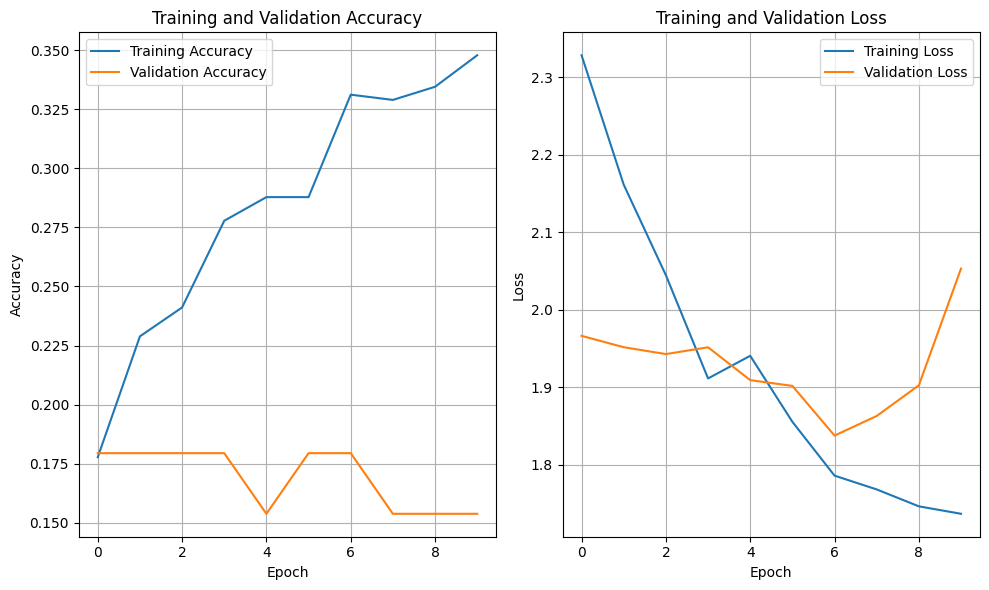

In [ ]:
# Extract the metrics from the history object
metrics_df = pd.DataFrame(history.history)

# Plot the training history for 'categorical_accuracy'
fig, axes= plt.subplots(1, 2, figsize=(10, 6))

# Plot Accuracy
sns.lineplot(ax= axes[0], x=metrics_df.index, y=metrics_df['categorical_accuracy'], label='Training Accuracy')
sns.lineplot(ax= axes[0], x=metrics_df.index, y=metrics_df['val_categorical_accuracy'], label='Validation Accuracy')
axes[0].set_title('Training and Validation Accuracy')
axes[0].set_xlabel('Epoch')
axes[0].set_ylabel('Accuracy')
axes[0].legend()
axes[0].grid(True)

# Plot Loss
sns.lineplot(ax= axes[1], x= metrics_df.index, y= metrics_df['loss'], label='Training Loss')
sns.lineplot(ax= axes[1], x= metrics_df.index, y= metrics_df['val_loss'], label='Validation Loss')
axes[1].set_title('Training and Validation Loss')
axes[1].set_xlabel('Epoch')
axes[1].set_ylabel('Loss')
axes[1].legend()
axes[1].grid(True)

plt.tight_layout()
plt.show()

In [ ]:
result = new_model.evaluate(test_generator, steps=steps_test)
print("Test-set classification accuracy: {0:.2%}".format(result[1]))

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


2/2 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step - categorical_accuracy: 0.1625 - loss: 2.0624
Test-set classification accuracy: 15.00%


# Unfreeze Resnet50 layers to retrain

In [ ]:
conv_model.trainable = True

In [ ]:
for layer in conv_model.layers:
  if('conv5' not in layer.name): # only layers from conv5 (the last block) remain trainable
    layer.trainable = False
  if('bn' in layer.name): # do not train batch normalization layers
    layer.trainable = False

In [ ]:
optimizer_fine_tuning = Adam(learning_rate=1e-3) # increasing learning rate because model is struggling to predict

In [ ]:
new_model.compile(optimizer=optimizer_fine_tuning, loss=loss, metrics=lst_metrics)

In [ ]:
new_model.summary()

Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ functional_34 (Functional)           │ (None, 7, 7, 2048)          │      23,587,712 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d             │ (None, 2048)                │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_11 (Dense)                     │ (None, 2048)                │       4,196,352 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_12 (Dense)                     │ (None, 1024)                │       2,098,176 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_13 (Dense)                     │ (None, 512)                 │         524,800 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_3 (Dropout)                  │ (None, 512)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_14 (Dense)                     │ (None, 6)                   │           3,078 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 30,410,118 (116.01 MB)

 Trainable params: 21,775,878 (83.07 MB)

 Non-trainable params: 8,634,240 (32.94 MB)

In [ ]:
fine_tuning_epochs = 40
total_epochs = initial_epochs + fine_tuning_epochs

In [ ]:
history_fine_tuning = new_model.fit(train_generator,
                    epochs=5, #already trained the new top for 10 epochs before unfreezing, starts counter at 11
                    steps_per_epoch=steps_train,
                    validation_data=val_generator
                    )

Epoch 1/5
29/29 ━━━━━━━━━━━━━━━━━━━━ 46s 933ms/step - categorical_accuracy: 0.1726 - loss: 5.1932 - val_categorical_accuracy: 0.1795 - val_loss: 1.8179
Epoch 2/5
29/29 ━━━━━━━━━━━━━━━━━━━━ 16s 564ms/step - categorical_accuracy: 0.1570 - loss: 1.8363 - val_categorical_accuracy: 0.1795 - val_loss: 1.7969
Epoch 3/5
29/29 ━━━━━━━━━━━━━━━━━━━━ 19s 501ms/step - categorical_accuracy: 0.1527 - loss: 1.8065 - val_categorical_accuracy: 0.1282 - val_loss: 1.7985
Epoch 4/5
29/29 ━━━━━━━━━━━━━━━━━━━━ 15s 527ms/step - categorical_accuracy: 0.1745 - loss: 1.7956 - val_categorical_accuracy: 0.1282 - val_loss: 1.7938
Epoch 5/5
29/29 ━━━━━━━━━━━━━━━━━━━━ 23s 615ms/step - categorical_accuracy: 0.1905 - loss: 1.7926 - val_categorical_accuracy: 0.1282 - val_loss: 1.7927


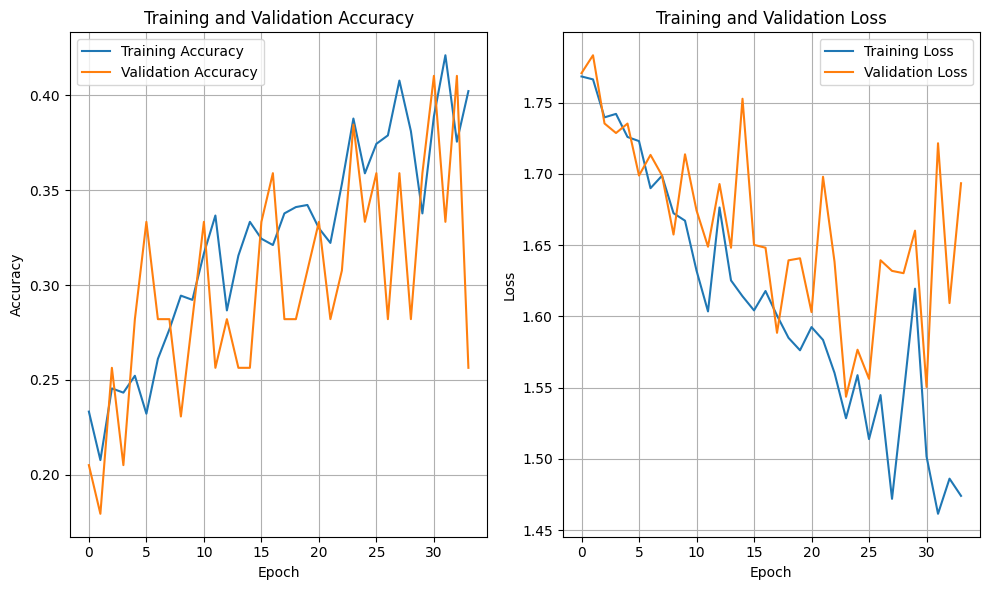

In [ ]:
# Extract the metrics from the history object
metrics_df = pd.DataFrame(history_fine_tuning.history)

# Plot the training history for 'categorical_accuracy'
fig, axes= plt.subplots(1, 2, figsize=(10, 6))

# Plot Accuracy
sns.lineplot(ax= axes[0], x=metrics_df.index, y=metrics_df['categorical_accuracy'], label='Training Accuracy')
sns.lineplot(ax= axes[0], x=metrics_df.index, y=metrics_df['val_categorical_accuracy'], label='Validation Accuracy')
axes[0].set_title('Training and Validation Accuracy')
axes[0].set_xlabel('Epoch')
axes[0].set_ylabel('Accuracy')
axes[0].legend()
axes[0].grid(True)

# Plot Loss
sns.lineplot(ax= axes[1], x= metrics_df.index, y= metrics_df['loss'], label='Training Loss')
sns.lineplot(ax= axes[1], x= metrics_df.index, y= metrics_df['val_loss'], label='Validation Loss')
axes[1].set_title('Training and Validation Loss')
axes[1].set_xlabel('Epoch')
axes[1].set_ylabel('Loss')
axes[1].legend()
axes[1].grid(True)

plt.tight_layout()
plt.show()

In [ ]:
# Unfreeze conv4 block after fine-tuning conv5
for layer in conv_model.layers:
  if not ('conv4' in layer.name or 'conv5' in layer.name):
    layer.trainable = False
  if 'bn' in layer.name:  # Keep BatchNormalization layers frozen
    layer.trainable = False

new_model.compile(optimizer=optimizer_fine_tuning, loss=loss, metrics=lst_metrics)
optimizer_fine_tuning = tf.keras.optimizers.Adam(learning_rate=)  # Lower learning rate for further fine-tuning
new_model.compile(optimizer=optimizer_fine_tuning, loss= loss, metrics=lst_metrics
                  )
history_fine_tuning = new_model.fit(train_ds,
                    epochs=total_epochs, # Fine-tune for more epochs
                    initial_epoch=history_fine_tuning.epoch[-1] + 1,
                    steps_per_epoch=steps_train,
                    validation_data=val_ds,
                    callbacks = [early_stopping_cb]
                    )